# <h1><center>Liepin Analysis</center></h1>
### <h1><center>Dailin Ji</center></h1>

## Contents
- Introduction
- Code
    - Scraping the webpage
    - Data Cleaning & Formatting
    - Analysis & Visualization
- Conclusion
    


# Introduction
### This notebook is created to provide an overview of recent Chinese high-end job market. All data is scraped from Liepin.com, one of the most popular recruting websites in China. Accessible data includes job titles, salaries, industries, education requirements, etc. After scraping and cleaning the data, we will perform an Exploratory Data Analysis to gain some interesting insights.

# Code

# 1. Scraping the webpage

## 1.1 Preparation

In [2]:
#import libraries
import random
import urllib.request
import urllib.parse
import pymysql
import re
import pandas as pd
import numpy as np

In [96]:
#create an empty dataframe to store the data
jobs = pd.DataFrame(columns = ['Job Title','Area','Industry','Education','PublishTime','Company','Salary'])

In [97]:
#define a function to handle missing values during scraping, returns NaN if the data is not found
def check_nan(l):
    if len(l) !=0:
        return l[0]
    else:
        return np.nan

## 1.2 Scraping the webpage
### Note: here we only scrape the jobs that offer ￥300000 per year, which are considered as high-paid positions. Other limitations, such as industries, locations, or companies, could be set by changing the input url.

In [3]:
agents = ['Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36 OPR/26.0.1656.60',
    'Mozilla/5.0 (Windows NT 5.1; U; en; rv:1.8.1) Gecko/20061208 Firefox/2.0.0 Opera 9.50',
    'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; en) Opera 9.50',
    'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:34.0) Gecko/20100101 Firefox/34.0',
    'Mozilla/5.0 (X11; U; Linux x86_64; zh-CN; rv:1.9.2.10) Gecko/20100922 Ubuntu/10.10 (maverick) Firefox/3.6.10',
    'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534.57.2 (KHTML, like Gecko) Version/5.1.7 Safari/534.57.2',
    'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.71 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
    'Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US) AppleWebKit/534.16 (KHTML, like Gecko) Chrome/10.0.648.133 Safari/534.16',
    'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.101 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko']


In [4]:
#input the copied url from liepin.com

#scrape 100 pages(maximum) for each industry type
for i in range(100):
    #append page# onto the url to access different pages
    url = 'https://www.liepin.com/zhaopin/?isAnalysis=&dqs=&pubTime=&salary=30%24200&subIndustry=&industryType=&compscale=&key=&init=-1&searchType=1&headckid=cafa81f719541b2f&compkind=&fromSearchBtn=2&sortFlag=15&ckid=3036bad9818b2cea&degradeFlag=0&jobKind=&industries=&clean_condition=&siTag=1B2M2Y8AsgTpgAmY7PhCfg%7E6ZEbwuW5cdcv1oASgSq8cQ&d_sfrom=search_fp_nvbar&d_ckId=8c4a2877253387feebc0207eeccf153c&d_curPage=2&d_pageSize=40&d_headId=3994ac3f906927f9c074c9c57abe8044&curPage='+str(i)
    #create a header
    headers = {} 
    headers['User-Agent'] = random.choice(agents)

    #scrape the page
    req = urllib.request.Request(url,headers=headers)
    resp = urllib.request.urlopen(req)
    respData = resp.read()

    #decode the document
    Ddata = respData.decode('utf-8')


    #split the webpage into different job sections
    data = Ddata.split('<div class="job-info">')

    #define the patterns
    job_pat='h3 title="(.*?)"'
    area_pat='class="area">(.*?)<'
    industry_pat='target="_blank">(.*?)<'
    industry_pat2='<span>\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t(.*?)\r\n\t'
    edu_pat='class="edu">(.*?)<'
    time_pat='time title="(.*?)"'
    company_pat='a title="(.*?)"'
    salary_pat='class="text-warning">(.*?)<'

    #regular expression and append the result to the dataframe
    for j in range(1,len(data)-1):

        job = check_nan(re.compile(job_pat).findall(data[j]))
        area = check_nan(re.compile(area_pat).findall(data[j]))

        #an expection, industry are stored in two different forms
        industry1 = re.compile(industry_pat).findall(data[j])
        industry2 = re.compile(industry_pat2).findall(data[j])
        industry = check_nan(industry1+industry2)

        edu = check_nan(re.compile(edu_pat).findall(data[j]))
        time = check_nan(re.compile(time_pat).findall(data[j]))
        company = check_nan(re.compile(company_pat).findall(data[j]))
        salary = check_nan(re.compile(salary_pat).findall(data[j]))

        #get a pandas series
        s = pd.Series([job,area,industry,edu,time,company,salary],index=['Job Title','Area','Industry','Education','PublishTime','Company','Salary'])
        #append the list to the dataframe
        jobs = jobs.append(s,ignore_index=True)
    print('Finished scraping page#'+str(i+1))

KeyboardInterrupt: 

## 1.3 Check the dataframe

In [138]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4619 entries, 0 to 4618
Data columns (total 9 columns):
Job Title      4618 non-null object
Salary         3979 non-null object
Industry       4316 non-null object
Education      4619 non-null object
PublishTime    4619 non-null object
Company        4619 non-null object
Area           4619 non-null object
Industry_2     1248 non-null object
Industry_3     946 non-null object
dtypes: object(9)
memory usage: 324.9+ KB


## 1.4 Export the data to a csv file

In [5]:
#delete duplicate records
jobs = jobs[jobs.duplicated() == False]
len(jobs)
jobs.to_csv('liepin.csv',index=False)

NameError: name 'jobs' is not defined

In [105]:
#jobs = pd.read_csv('liepin.csv')
#jobs.head()
jobs.shape

(3834, 7)

# 2. Data Cleaning & Formatting

## 2.1 Job titles: The title/name of this position
### The word '招聘‘ seems to be redundant, so get rid of it.

In [106]:
#use slicing to remove the first two characters
jobs['Job Title'] = jobs['Job Title'].str[2:]
#jobs.head(1)

## 2.2 Area: The base of this job
### There are some jobs that are recruting in multiple locations, let's separate them into different rows, while keep other information unchanged

### credit: https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe

In [107]:
test = jobs
from itertools import chain


def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))


lens = test['Area'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
jobs = pd.DataFrame({'Job Title': np.repeat(test['Job Title'], lens),
                    'Salary': np.repeat(test['Salary'], lens),
                    'Industry': np.repeat(test['Industry'], lens),
                    'Education': np.repeat(test['Education'], lens),
                    'PublishTime': np.repeat(test['PublishTime'], lens),
                    'Company': np.repeat(test['Company'], lens),
                    'Area': chainer(test['Area']),
                    })
jobs.reset_index(drop = True, inplace = True)
del test

### Some areas are stored as 'City-districts', so we will only keep the city names

In [108]:
location=jobs['Area'].str.split('-',expand=True)
jobs['Area']= location[0]
#jobs.head()

## 2.3 Salary: Expected yearly package offered by company
### There are some jobs that don't offer a excat amount of salaries (‘面议’，as ‘to be discussed’, so set them to NaN values for convenience

In [109]:
#(1)
len(jobs[jobs.Salary == '面议'])

640

In [110]:
jobs['Salary']=jobs['Salary'].replace('面议',np.nan)
len(jobs[jobs.Salary == '面议'])

0

### Other vaild salaries are stored with a range, let's only take the max value

In [111]:
#(2)
new=jobs['Salary'].str.split('-',expand=True)
jobs['Salary']= new[1]
jobs['Salary']=jobs['Salary'].str[:-1]

## 2.4 Education: Minimum degree required for this job

In [112]:
jobs['Education'].unique()

array(['本科及以上', '统招本科', '硕士及以上', '大专及以上', '学历不限', '博士', '中专/中技及以上'],
      dtype=object)

### There are 8 distinct categories for education requirements.'统招本科’ and ‘本科及以上’ seems to have similar meanings, so let's replace both with '本科‘.

In [113]:
jobs['Education']=jobs['Education'].replace(['本科及以上','统招本科'],'本科')
jobs['Education'].unique()

array(['本科', '硕士及以上', '大专及以上', '学历不限', '博士', '中专/中技及以上'], dtype=object)

## 2.5 PublishTime: The time of this job was posted

In [114]:
jobs['PublishTime'].nunique()

7

### This dataset has records for the last 119 days, almost 4 months. 

## 2.6 Company: The name of recruiting company
### Just like 'Job Title', we need to get rid of the first two characters

In [115]:
jobs['Company'] = jobs['Company'].str[2:]
#jobs.head(1)

## 2.7 Industry: The industry categories of the company
### Some companies belong to multiple industries, let's seperate them into different columns.

In [116]:
industries=jobs['Industry'].str.split('，',expand=True)
jobs['Industry']= industries[0]
jobs['Industry_2']=industries[1]
jobs['Industry_3']=industries[2]

# 3. Analysis & Visualization

In [154]:
#jobs.shape()
print('The dataset contains information for',str(jobs.shape[0]),'jobs.')

The dataset contains information for 4601 jobs.


## 3.1 Word cloud for all job titles

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/jieba.cache
Loading model cost 0.836 seconds.
Prefix dict has been built succesfully.


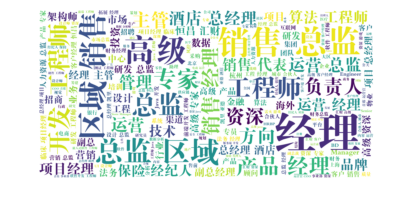

In [119]:

#import libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import  jieba  
import seaborn as sns

#concat all job titles into string and cut into words
string = jobs['Job Title'].str.cat()
cut_text = " ".join(jieba.cut(string))

#generate the word cloud
wordcloud = WordCloud(
    font_path="ziti.ttf",
    background_color="white",width=3000,height=1500).generate(cut_text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3.2 Jobs count Vs. Area (Top 10)

In [120]:
#modifiy the library so it is able to display Chinese in the graph
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [121]:
#define a function to do group_count
def group_count(group,limit):
    df = jobs.groupby([group])[['Company']].count()
    df = df.reset_index()
    df.columns = [group,'Count']
    plt.figure(figsize=(12, 10))
    graph = sns.barplot(data=df.sort_values(by='Count', ascending=False).head(limit), x='Count', y=group)
    return graph

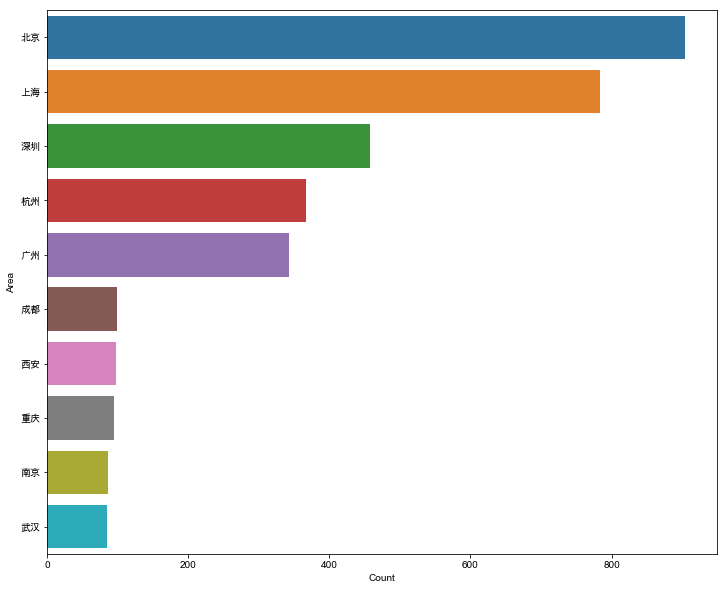

In [122]:
group_count('Area',10)


### Analysis: High paid jobs are mostly located in large cities

## 3.3 Jobs count Vs. Education

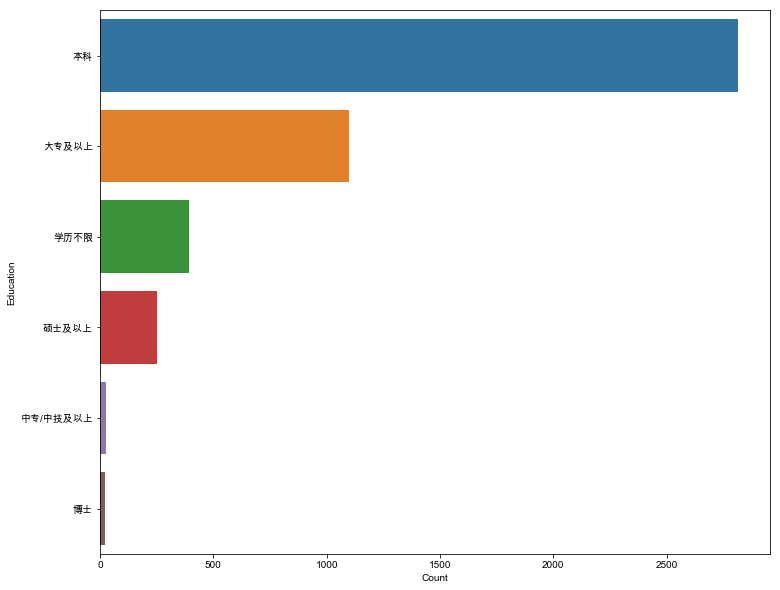

In [151]:
group_count('Education',10)

### Analysis: Most jobs require a bachelor degree. It is surprising that many high-paid jobs also don't have a minimum requirement. It is probably because managerial positions often emphasize more on the practical experience

## 3.4 Jobs count Vs. Industry (Top 20)

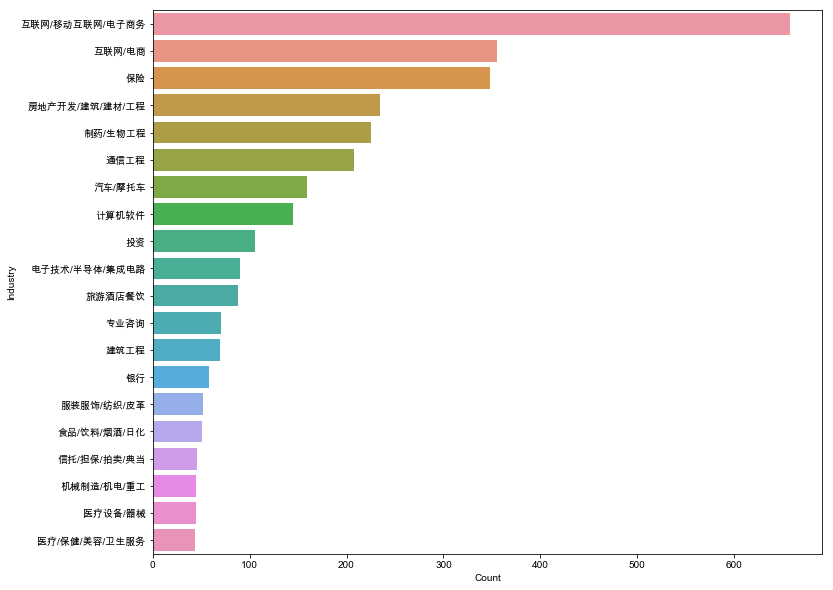

In [150]:
group_count('Industry',20)

### Analysis: Here we can see the rapid development of internet industries. Financing industries also played important roles

## 3.4 Average Salary Vs. Area (Top 10)

In [146]:
#define a function to find groups' average salary
def group_mean(group,limit,min_jobs):
    df = jobs[[group,'Salary']]
    df['Salary'] = df['Salary'].astype('float')
    df_salary = df.groupby([group])[['Salary']].mean()
    df_salary = df_salary.reset_index()
    df_count = df.groupby([group])[['Salary']].count()
    df_count = df_count.reset_index()
    df = df_salary.merge(df_count, on = group)
    df.columns = [group,'Salary','Count']
    df = df[df.Count > min_jobs]
    graph = sns.barplot(data=df.sort_values(by='Salary', ascending=False).head(limit), x='Salary', y=group)
    return graph

### In order to aviod outliers and bias, we will only take the cities that has more than 100 offers

/Users/gideon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


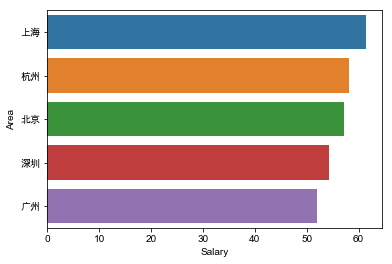

In [147]:
group_mean('Area',20,100)

### Analysis: Jobs in Shanghai offer the most among all locations. It is probably because many foreign companies are based there, and they typically offer a higer package than domestic ones. 

/Users/gideon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


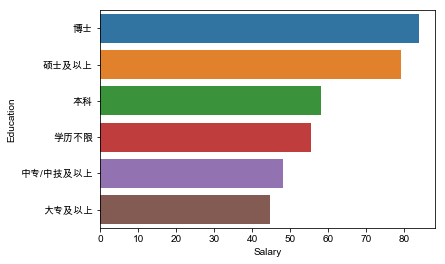

In [153]:
group_mean('Education',20,0)

### Analysis: Reasonably, better education returns a higher package. The average salary of a doctor is around ￥800000 per year. 

/Users/gideon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


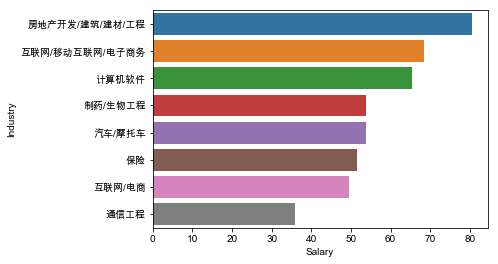

In [149]:
group_mean('Industry',20,100)

### Analysis: Although internet industries have more jobs opening, they don't offer the most. Real estate industry takes the lead, and E-commerce follows. 

# Conclusion

### For headhunts and professional recruiters, it is important to pay attention to internet industries. There is a strong need for excellent human resources, and packages are considerable, which gives high commision fees.